In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from tqdm import tqdm


from full_dynamics import FullSimulation

In [2]:
def theory_Jcrit(alpha, kappa, L=100):
    coth = 1/np.tanh(L * np.sqrt(alpha/(8*kappa)))
    return np.sqrt(2*alpha*kappa) / ( coth - 1/L * np.sqrt(8*kappa/alpha))

kappas = np.linspace(0.00001, 2.0, 10000)


In [3]:
def create_uniform_bump(N, center, width = 0.33, transition_width_factor = 4):
    # Create the array of zeros
    array = np.zeros(N)
    
    # Define the bump width (uniform region)
    bump_width = int(N * width)
    
    # Define the smooth transition width
    transition_width = bump_width // transition_width_factor # Adjust transition width as needed
    
    # Calculate indices for the uniform and transition regions
    start_uniform = int(center*N - bump_width/ 2)
    end_uniform = start_uniform + bump_width
    start_transition = max(0, start_uniform - transition_width)
    end_transition = min(N, end_uniform + transition_width)
    
    # Uniform region
    array[start_uniform:end_uniform] = 1.0
    
    # Smooth transitions
    if transition_width > 0:
        # Left transition
        left_transition = np.linspace(-np.pi, 0, start_uniform - start_transition)
        array[start_transition:start_uniform] = 0.5 * (1 + np.cos(left_transition))
        
        # Right transition
        right_transition = np.linspace(0, np.pi, end_transition - end_uniform)
        array[end_uniform:end_transition] = 0.5 * (1 + np.cos(right_transition))
    
    return array

# Pump flux
def pump_flux(x, c, J_0, dx, N):
    """
    Compute the left-to-right pump flux, localized at the center of the domain.
    """
    pump_profile = np.zeros(N)
    pump_profile[int(N/2)] = 1/(dx)  # Delta function at the center
    #pump_profile = np.exp(-((x - pump_center)**2) / (2 * pump_width**2)) * 1/(np.sqrt(2*np.pi)*pump_width)
    return J_0 * pump_profile * (c[int(N/2)+1] - c[int(N/2)-1])/(2*dx)

# Free energy derivative
def dfdc(c, W):
    """
    Derivative of the bulk free energy density with an additional potential V(x).
    """
    return W * c * (c-1) * (c-0.5)

def run_sim(
    # Simulation parameters
    L = 50.0,     # Length of the domain
    N = 1024,      # Number of grid points
    
    # Physical parameters
    alpha = 1.0,       # Bulk free energy coefficient
    kappa = 1.0,   # Gradient energy coefficient

    pump_width = 0.1,
    J_0 = 0.0, 
    
    dt = 0.01,
    T = 1000, 
    delta = 0.01,
    show_progress=True):


    # Fourier space grid
    dx = L / N
    x = np.linspace(0, L, N, endpoint=False)
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Wavevector
    K2 = kx**2
    kmax_dealias = kx.max() * 2.0 / 3.0
    dealias = np.abs(kx) < kmax_dealias

    # Pump parameters

    pump_center = L / 2


    Nsteps = int(T / dt)  # Number of time steps
    c = np.empty((Nsteps // 100 + 1, N), dtype=np.float32)  # Save every 100th timestep
    c[0] = 1.0*create_uniform_bump(N, 0.5, 0.5, transition_width_factor=100) + delta *np.random.rand(N) #+ np.linspace(0, 0.2, N)
    c_hat = fft(c[0])  # Initial Fourier transform

    J = []
    # Main simulation loop
    for i in tqdm(range(1, Nsteps + 1), disable=(not show_progress)):
        c_real = ifft(c_hat).real  # Transform concentration to real space
        # Compute the Fourier transform of the derivative of free energy
        dfdc_hat = fft(dfdc(c_real, alpha)) * dealias

        # Compute the pump flux in real space
        J_pump = pump_flux(x, c_real, J_0, dx, N)

        # Transform the pump flux to Fourier space, including the derivative operator i*k
        J_pump_hat = 1j * kx * fft(J_pump) * dealias    
        #J_pump_hat = - J_0 * 1j * kx * c_hat * dealias

        # Update the Fourier components of the concentration field
        c_hat = (c_hat - dt * K2 * dfdc_hat - dt * J_pump_hat) / (1 + dt * kappa * K2**2)


        # Save every 100th timestep
        if i % 100 == 0:
            c[i // 100] = ifft(c_hat).real

            current_hat = J_pump_hat + K2 * dfdc_hat + kappa * K2**2 * c_hat
            #passive_current = K2 * dfdc_hat + kappa * K2**2 * c_hat
            J.append(ifft(current_hat).real)


    return c, np.array(J)





In [4]:
#PW_history, J = run_sim(alpha=1.0, kappa=1.0, J_0=1.8, delta=0.01, T=2000, L=100, N=5001)
#np.save('PW_history.npy', PW_history)

In [5]:
#FW_history, J = run_sim(alpha=1.0, kappa=1.0, J_0=1.0, delta=0.01, T=2000, L=100, N=5001)
#np.save('FW_history.npy', FW_history)

In [6]:
PW_history = np.load('data/PW_history.npy')
FW_history = np.load('data/FW_history.npy')


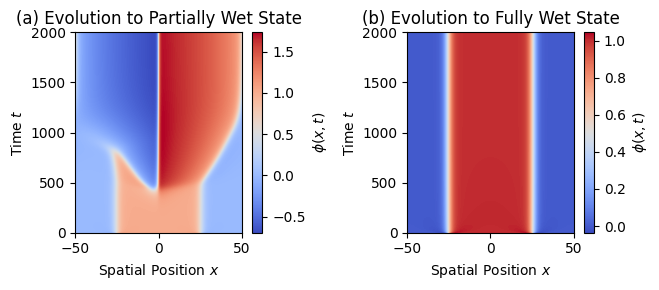

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6.67, 3.0))

# Left plot
axes[0].imshow(np.flip(PW_history, axis=1), aspect='auto', origin='lower', extent=[-50, 50, 0, 2000], cmap='coolwarm')
axes[0].set_title("(a) Evolution to Partially Wet State")
axes[0].set_xlabel(r"Spatial Position $x$")
axes[0].set_ylabel(r"Time $t$")
fig.colorbar(axes[0].images[0], ax=axes[0], label=r'$\phi(x, t)$')

# Right plot
axes[1].imshow(FW_history, aspect='auto', origin='lower', extent=[-50, 50, 0, 2000], cmap='coolwarm')
axes[1].set_title("(b) Evolution to Fully Wet State")
axes[1].set_xlabel(r"Spatial Position $x$")
axes[1].set_ylabel(r"Time $t$")
fig.colorbar(axes[1].images[0], ax=axes[1], label=r'$\phi(x, t)$')

plt.tight_layout()
#plt.savefig('Fig_PW_FW_evolution.pdf', bbox_inches='tight')
plt.show()


In [8]:
def AS(arr):
    rho = arr[:]
    return np.sum(np.abs(rho-np.roll(np.flip(rho), -1)))/(2*np.shape(rho)[0]*(np.mean(rho) - 0))



In [9]:
def create_uniform_bump(N, center, width = 0.33, transition_width_factor = 4):
    # Create the array of zeros
    array = np.zeros(N)
    
    # Define the bump width (uniform region)
    bump_width = int(N * width)
    
    # Define the smooth transition width
    transition_width = bump_width // transition_width_factor # Adjust transition width as needed
    
    # Calculate indices for the uniform and transition regions
    start_uniform = int(center*N - bump_width/ 2)
    end_uniform = start_uniform + bump_width
    start_transition = max(0, start_uniform - transition_width)
    end_transition = min(N, end_uniform + transition_width)
    
    # Uniform region
    array[start_uniform:end_uniform] = 1.0
    
    # Smooth transitions
    if transition_width > 0:
        # Left transition
        left_transition = np.linspace(-np.pi, 0, start_uniform - start_transition)
        array[start_transition:start_uniform] = 0.5 * (1 + np.cos(left_transition))
        
        # Right transition
        right_transition = np.linspace(0, np.pi, end_transition - end_uniform)
        array[end_uniform:end_transition] = 0.5 * (1 + np.cos(right_transition))
    
    return array

# Pump flux
def pump_flux(x, c, J_0, pump_center, pump_width, dx, N):
    """
    Compute the left-to-right pump flux, localized at the center of the domain.
    """
    pump_profile = np.exp(-((x - pump_center)**2) / (2 * pump_width**2)) * 1/(np.sqrt(2*np.pi)*pump_width)
    return J_0 * c * pump_profile * (c[int(N/2)+1] - c[int(N/2)-1])/(2*dx)

# Free energy derivative
def dfdc(c, W):
    """
    Derivative of the bulk free energy density with an additional potential V(x).
    """
    return W * c * (c-1) * (c-0.5)

def run_sim(
    # Simulation parameters
    L = 50.0,     # Length of the domain
    N = 1024,      # Number of grid points
    
    # Physical parameters
    alpha = 1.0,       # Bulk free energy coefficient
    kappa = 1.0,   # Gradient energy coefficient

    pump_width = 0.1,
    J_0 = 0.0, 
    
    dt = 0.01,
    T = 1000, 
    delta = 0.01,
    show_progress=True):


    # Fourier space grid
    dx = L / N
    x = np.linspace(0, L, N, endpoint=False)
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Wavevector
    K2 = kx**2
    kmax_dealias = kx.max() * 2.0 / 3.0
    dealias = np.abs(kx) < kmax_dealias

    # Pump parameters

    pump_center = L / 2


    Nsteps = int(T / dt)  # Number of time steps
    c = np.empty((Nsteps // 100 + 1, N), dtype=np.float32)  # Save every 100th timestep
    c[0] = 1.0*create_uniform_bump(N, 0.5, 0.5, transition_width_factor=100) + delta *np.random.rand(N) #+ np.linspace(0, 0.2, N)
    c_hat = fft(c[0])  # Initial Fourier transform

    J = []
    # Main simulation loop
    for i in tqdm(range(1, Nsteps + 1), disable=(not show_progress)):
        c_real = ifft(c_hat).real  # Transform concentration to real space
        # Compute the Fourier transform of the derivative of free energy
        dfdc_hat = fft(dfdc(c_real, alpha)) * dealias

        # Compute the pump flux in real space
        J_pump = pump_flux(x, c_real, J_0, pump_center, pump_width, dx, N)

        # Transform the pump flux to Fourier space, including the derivative operator i*k
        J_pump_hat = 1j * kx * fft(J_pump) * dealias    

        # Update the Fourier components of the concentration field
        c_hat = (c_hat - dt * K2 * dfdc_hat - dt * J_pump_hat) / (1 + dt * kappa * K2**2)


        # Save every 100th timestep
        if i % 100 == 0:
            c[i // 100] = ifft(c_hat).real
            
            phi =  ifft(c_hat).real
            grad_c = (phi - np.roll(phi, -1))/dx
            grad3_c = (np.roll(grad_c, 1) + np.roll(grad_c, -1) - 2*grad_c)/dx**2

            current_hat = J_pump_hat + K2 * dfdc_hat + kappa * K2**2 * c_hat
            J.append(ifft(current_hat).real)


    return c, np.array(J)





In [10]:
'''evols = []
ASs = np.concatenate((np.linspace(0, 0.8, 9), np.linspace(0.85, 1.3, 9), np.linspace(1.3, 2.0, 8)))
for J_0 in tqdm(ASs):
    c = run_sim(alpha=0.5, kappa=1.0, J_0=J_0, delta=0.01, T=2000, L=100, N=2001, show_progress=False)
    evols.append(c)

final_asymmetries_fig5b = [AS(c[-1]) for c in evols]
np.save('final_asymmetries_fig5b', final_asymmetries_fig5b)'''

"evols = []\nASs = np.concatenate((np.linspace(0, 0.8, 9), np.linspace(0.85, 1.3, 9), np.linspace(1.3, 2.0, 8)))\nfor J_0 in tqdm(ASs):\n    c = run_sim(alpha=0.5, kappa=1.0, J_0=J_0, delta=0.01, T=2000, L=100, N=2001, show_progress=False)\n    evols.append(c)\n\nfinal_asymmetries_fig5b = [AS(c[-1]) for c in evols]\nnp.save('final_asymmetries_fig5b', final_asymmetries_fig5b)"

In [11]:
final_asymmetries_fig5b = np.load('data/final_asymmetries_fig5b.npy')
ASs = np.concatenate((np.linspace(0, 0.8, 9), np.linspace(0.85, 1.3, 9), np.linspace(1.3, 2.0, 8)))

In [12]:
alpha = 1
kappas = np.linspace(0.2, 2.0, 10)
'''
params = []
AS_series = []

def AS(arr):
    rho = arr[:]
    return np.sum(np.abs(rho-np.roll(np.flip(rho), -1)))/np.sum(np.abs(rho+np.flip(rho)))


for kappa in tqdm(kappas):
    J_theory = theory_Jcrit(alpha, kappa, L=50)
    for J_0 in np.linspace(J_theory - 0.5, J_theory + 0.5, 6):
        
        c, J = run_sim(alpha=alpha, kappa=kappa, J_0=J_0, delta=0.001, T=200, L=100, N=20001, pump_width=0.01, show_progress=False)
        AS_series.append([AS(rho) for rho in c])
        params.append([kappa, J_0])
        #print('doen')

params = np.array(params)
final_AS = np.array([AS[-1] for AS in AS_series])

np.savez('AS_series', params=params, final_AS=final_AS, AS_series=AS_series)'''

"\nparams = []\nAS_series = []\n\ndef AS(arr):\n    rho = arr[:]\n    return np.sum(np.abs(rho-np.roll(np.flip(rho), -1)))/np.sum(np.abs(rho+np.flip(rho)))\n\n\nfor kappa in tqdm(kappas):\n    J_theory = theory_Jcrit(alpha, kappa, L=50)\n    for J_0 in np.linspace(J_theory - 0.5, J_theory + 0.5, 6):\n        \n        c, J = run_sim(alpha=alpha, kappa=kappa, J_0=J_0, delta=0.001, T=200, L=100, N=20001, pump_width=0.01, show_progress=False)\n        AS_series.append([AS(rho) for rho in c])\n        params.append([kappa, J_0])\n        #print('doen')\n\nparams = np.array(params)\nfinal_AS = np.array([AS[-1] for AS in AS_series])\n\nnp.savez('AS_series', params=params, final_AS=final_AS, AS_series=AS_series)"

In [13]:
data = np.load('data/AS_series.npz')
params = data['params']
final_AS = data['final_AS']
AS_series = data['AS_series']

def state(AS_hist):
    if AS_hist[-1] > 0.18*10**(-4) or (AS_hist[-1] - AS_hist[-2] )/AS_hist[-1] > 1*10**(-3):
        return 1
    else:
        return 0

states = [state(series) for series in AS_series]

In [14]:
def AS(arr):
    rho = arr[:]
    return np.sum(np.abs(rho-np.roll(np.flip(rho), -1)))/(2*np.shape(rho)[0]*(np.mean(rho) - 0))

In [15]:
PW_history, J = run_sim(alpha=1.0, kappa=1.0, J_0=2.0, delta=0.01, T=3000, L=100, N=2001)

 40%|████      | 120589/300000 [00:12<00:18, 9717.92it/s] 


KeyboardInterrupt: 

/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_93738/1100059033.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  coth = 1/np.tanh(L * np.sqrt(alpha/(8*kappa)))
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_93738/266877727.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.0)  # Increase padding to avoid clipping


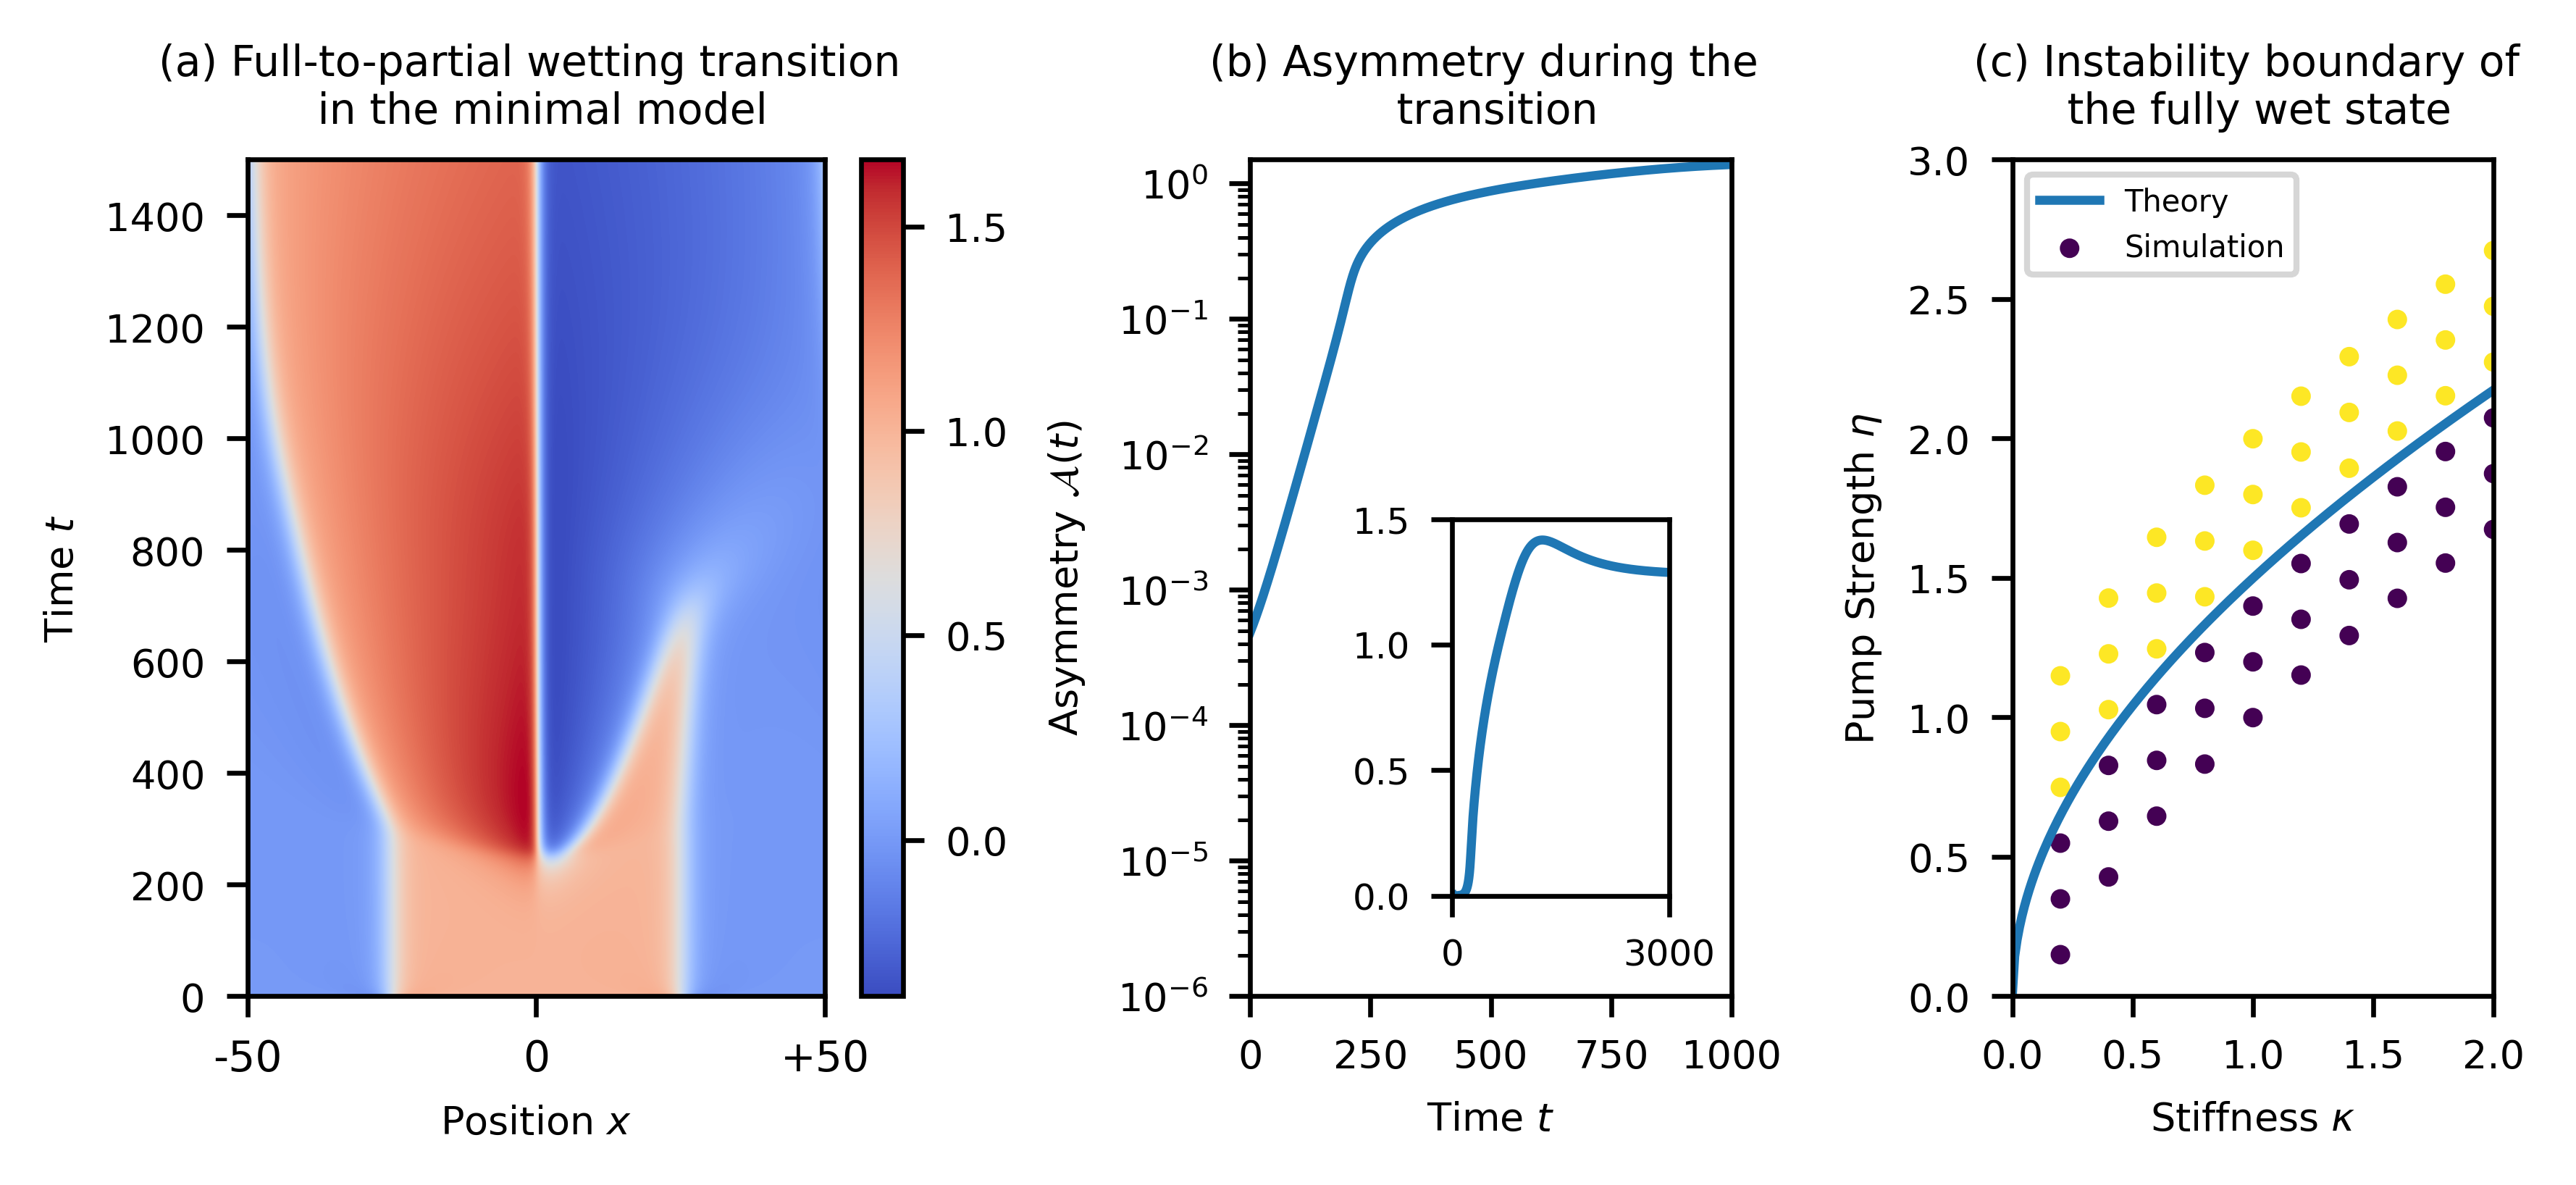

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(6.67, 2.5), width_ratios=[1.5, 1, 1], gridspec_kw={'wspace': 0.5}, dpi=600)
plt.rcParams.update({'font.size': 6.5})
im = axes[0].imshow(PW_history[:1500, :], extent=[0, 100, 0, 1500], aspect='auto', origin='lower', cmap='coolwarm')
cbar = fig.colorbar(im, ax=axes[0])#, orientation='horizontal', pad=0.2)
cbar.set_ticks([0, 0.5, 1.0, 1.5])
#cbar.set_ticklabels(['Low', 'Medium', 'High'])
axes[0].set_xlabel(r'Position $x$')
axes[0].set_ylabel(r'Time $t$')
axes[0].set_xticks([0, 50, 100])
axes[0].set_xticklabels(['-50', '0', '+50'], fontsize=7)
axes[0].set_title('(a) Full-to-partial wetting transition \n in the minimal model', fontsize=7)


#axes[1].plot(ASs, final_asymmetries_fig5b, marker='x', markersize=5, label=r'$\mathcal{A}(t=2000)$')
#axes[1].set_xlabel(r'Current Amplitude $J_0$')
#axes[1].set_ylabel(r'Asymmetry $\mathcal{A}(t=10^4)$')
#axes[1].set_title('(b)')

axes[1].plot([AS(rho) for rho in PW_history][50:])
axes[1].set_yscale('log')
axes[1].set_xlim(0, 1000)
axes[1].set_title('(b) Asymmetry during the \n transition', fontsize=7)
axes[1].set_ylim(10**(-6), 1.5)
axes[1].set_xlabel(r'Time $t$')
axes[1].set_ylabel(r'Asymmetry $\mathcal{A}(t)$', labelpad=5)

#  Create an inset within axes[1]
inset_ax = axes[1].inset_axes([0.42, 0.12, 0.45, 0.45])  # [x, y, width, height] in axes fraction
inset_ax.plot([AS(rho) for rho in PW_history], label=r' $\mathcal{A}(t=2000)$')
inset_ax.tick_params(axis='both', which='major', labelsize=6)
inset_ax.set_xticks([0, 3000])
inset_ax.set_xlim(0, 3000)
inset_ax.set_ylim(0, 1.5)

kappas_cont = np.linspace(0.0, 2.0, 200)
axes[2].plot(kappas_cont, [theory_Jcrit(1.0, kappa, L=50) for kappa in kappas_cont], label=r"Theory")
axes[2].scatter(params[:,0], params[:,1], c=states, cmap='viridis', s=5, vmin=0, vmax=0.2*10**(-4), label="Simulation")
axes[2].set_xlabel(r"Stiffness $\kappa$")
axes[2].set_ylim(0, 3.0)
axes[2].set_xlim(0, 2.0)
axes[2].set_ylabel(r"Pump Strength $\eta$")
axes[2].set_title('(c) Instability boundary of \n the fully wet state', fontsize=7)
axes[2].legend(loc='upper left', fontsize=5)

plt.tight_layout(pad=0.0)  # Increase padding to avoid clipping

#plt.savefig('Fig_CHpump.pdf', dpi=600, bbox_inches='tight')  # Use bbox_inches='tight' to include all elements